 ### Lets create some manipulating and visualizing the dataset
 A secondary purpose of this notebook is to be an introduction to basic Python, the pandas data analytics library and matplotlib.

 We start with importing the libraries and tools we'll need for the rest of the notebook.

In [1]:
#We don't use seaborn in this particular notebook, but it makes matplotlib charts look nicer.
import seaborn as sns 

import osmnx as ox

#Pandas for data analysis
import pandas as pd
from pandas import Series,DataFrame

#To display the figures in the notebook itself.
%matplotlib inline

The results for the Walkability Workflow will be collected from an som xml file. We can open it using pandas and load its contents in a pandas dataframe object.

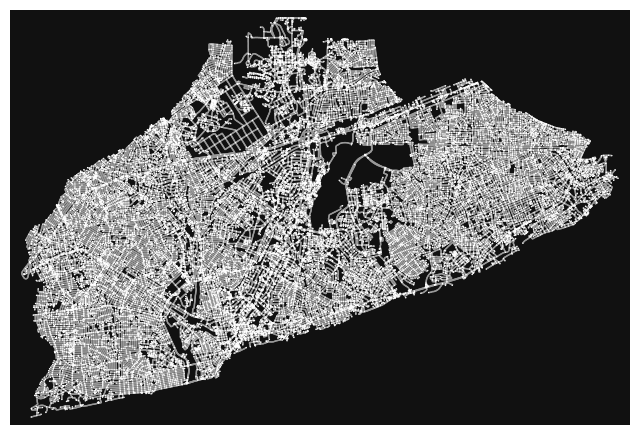

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
suburb_name = "Accra"

graph = ox.graph_from_place(suburb_name, network_type="walk")

ox.plot_graph(graph, node_size=1)

In [ ]:
walkable_roads = ['footway', 'pedestrian', 'path', 'living_street']

G_walk = ox.graph_from_place(suburb_name, network_type='walk', custom_filter=f"{' or '.join(walkable_roads)}")
